## Importing modules

In [1]:
import os
cwd = os.getcwd() # This fn will return the Current Working Directory
print(cwd)
import numpy as np
from skimage import io
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import cv2
from PIL import Image
import imageio




u:\Ella_Anderson


In [3]:
stack_path = r"U:\Ella_Anderson\200tappingtest2_stack.tif"
print("File exists:", os.path.exists(stack_path))
print("Can read file:", os.access(stack_path, os.R_OK))
stack = tifffile.imread(stack_path)
print(len(stack))
#should take approx 15 seconds to load


File exists: True
Can read file: True
200


In [54]:
%pip install numpy matplotlib opencv-python ffmpeg scipy scikit-image

Note: you may need to restart the kernel to use updated packages.


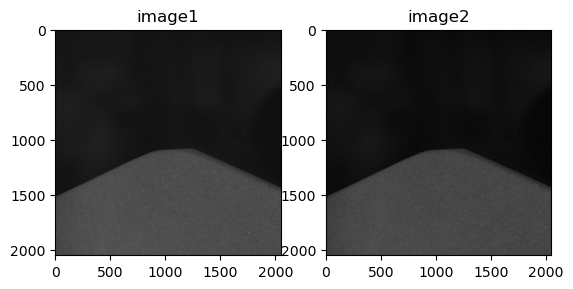

In [4]:
img1 = stack[10]
img2 = stack[11] #extracting two images from the tiff file
odims = img1.shape #getting the dimensions of the tiff files

blocksize = 512 #breaking the image into metapixels of dimensions of 16x16 or 8x8 rather than one large picture with dimensions 2048x2048

plt.subplot(1, 2, 1)
plt.title('image1')
plt.imshow(img1, cmap='gist_gray')
plt.subplot(1,2,2)
plt.title('image2')
plt.imshow(img2, cmap='gist_gray')



In [5]:

#two image correlation function

def gotta_do_what_you_gotta_do(img1, img2, blocksize):
    
    blocks3 = [np.hsplit(x,blocksize) for x in np.vsplit(img1,blocksize)]
    blocks3final = np.asarray(blocks3)


    blocks4 = [np.hsplit(x,blocksize) for x in np.vsplit(img2,blocksize)]
    blocks4final = np.asarray(blocks4)


    blocks3final = blocks3final.astype(np.uintc)
    blocks4final = blocks4final.astype(np.uintc)

    blocks3mean = np.mean(blocks3final, axis=(2,3))
    blocks4mean = np.mean(blocks4final, axis=(2,3))

    
    multiplication = blocks3final * blocks4final #only the 128x128 value
    blocks3finalsquared = blocks3final * blocks3final
    blocks4finalsquared = blocks4final * blocks4final
    average = np.mean(multiplication, axis=(2,3))

    cimg = np.zeros(blocks3final.size) 
    
    cimg = (((np.mean(multiplication, axis=(2,3))) - (blocks3mean*blocks4mean)) / \
    (np.sqrt(np.mean(blocks3finalsquared, axis=(2,3)) - np.square(blocks3mean)) * np.sqrt(np.mean(blocks4finalsquared, axis=(2,3)) - np.square(blocks4mean))))
    
    mask = blocks3mean <= 9500
    cimg[mask] = 1
    
    #cimg_scaled = (cimg + 0.5)/1.5
    return cimg

cimg = gotta_do_what_you_gotta_do(img1, img2, blocksize)

print(np.min(cimg))
print(np.max(cimg))



0.002792097701530534
1.0


Text(0.5, 1.0, 'strain of an image (need units)')

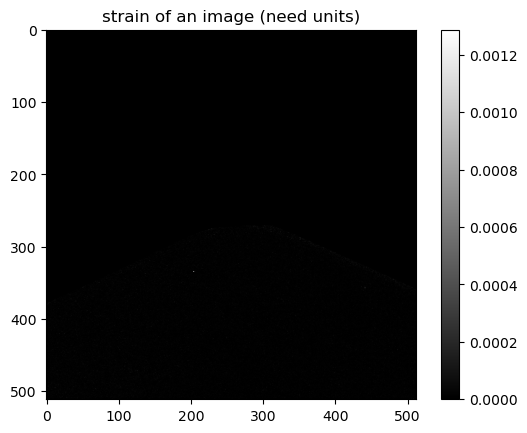

In [6]:
"""
calculating strain

"""

from matplotlib.colors import LinearSegmentedColormap

c = (8*np.pi)*(np.sqrt((2/5)*(3.3*0.0001)) / 0.0000632)

strainl = -np.log(cimg)/c

white_to_black = LinearSegmentedColormap.from_list('white_to_black', [(1, 1, 1), (0, 0, 0)])

y = plt.imshow(strainl, cmap='gist_gray')
plt.colorbar(y)
plt.title("strain of an image (need units)")
#632 = lambda, 3.3 = l*

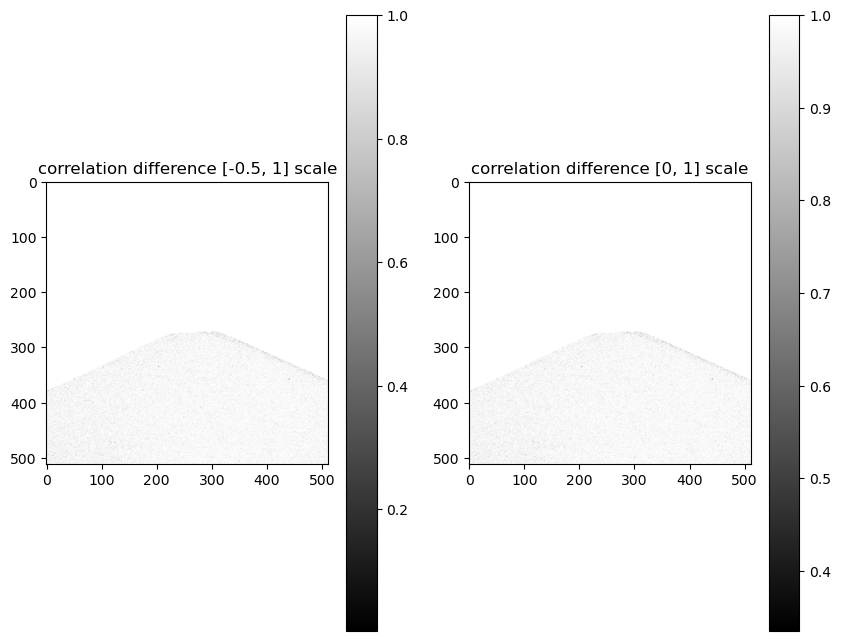

In [7]:
cimg_scaled = (cimg + 0.5)/1.5
#scaling the images so the distribution is [0,1]


#plotting the correlation between two images
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.title("correlation difference [-0.5, 1] scale")
h = plt.imshow(cimg, cmap='gist_gray')
plt.colorbar(h)
plt.subplot(1,2,2)
plt.title("correlation difference [0, 1] scale")
j = plt.imshow(cimg_scaled, cmap='gist_gray')
plt.colorbar(j)


output_path = 'correlation_image.tif'
output_path2 = 'correlation_cimg_scaled.tif'

cimg_scaled32 = cimg_scaled.astype(np.float32)
cimg32 = cimg.astype(np.float32)
imageio.imwrite(output_path, cimg32)
imageio.imwrite(output_path2, cimg_scaled32)
plt.show()




In [8]:

"""

right now the block size is 4x4 because the initial experiment had blocksizes of 10

"""
#creating the stack of images 
stack = tifffile.imread(stack_path)
clist=[]
strainlist = []
strainsumlist = []

start_index = 0
end_index = 200

for p in range(start_index, end_index):
    
    img1 = stack[p] #adjusted so that each consecutive image is being compared with the 1st image in the stack...like aggregation of particlse
    img2 = stack[p+1]
    cimg = gotta_do_what_you_gotta_do(img1, img2, blocksize)
    cimg_scaled = (cimg + 0.5)/1.5
    clist.append(cimg_scaled)
    
    c = (8*np.pi)*(np.sqrt((2/5)*(3.3*0.0001)) / 0.0000632)
    strainl = -np.log(cimg)/c
    strainlist.append(strainl)
    
    strainsum = np.nansum(strainl) #use nansum to avoid nan values when calculating the sum
    
    strainsumlist.append(strainsum)
    
    print(p)

print("Can save them as individual tiff files then do a tiff stack in imagej")
print("For blocksize of 8x8, it takes approx 30 seconds to load 20 images. For 16x16, it was under 20 seconds.")


0
1
2
3
4
5
6
7
8


C:\Users\burtonlabuser\AppData\Local\Temp\ipykernel_18544\2929530541.py:24: RuntimeWarning: invalid value encountered in log
  strainl = -np.log(cimg)/c


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


C:\Users\burtonlabuser\AppData\Local\Temp\ipykernel_18544\2929530541.py:24: RuntimeWarning: divide by zero encountered in log
  strainl = -np.log(cimg)/c


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


IndexError: index 200 is out of bounds for axis 0 with size 200

0.08001977439189457
0.07130629153846794
0.07150297199484643
0.07301776221893107
0.07027939270553599
0.06930290626119699
0.07130791232208476
0.07524824798965983
0.07823825036331485
1.2056295426495847


<function matplotlib.pyplot.show(close=None, block=None)>

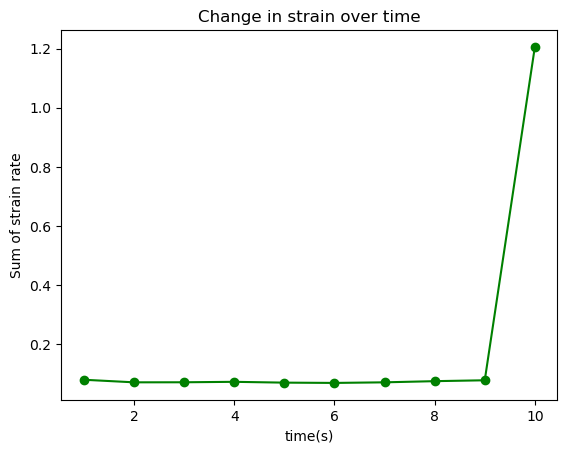

In [9]:
#valid_strainpoints = ~np.isnan(strainsumlist)
#t = list(range(1, len(valid_strainpoints)+1))
strainsum_normalizedlist = []
for i in strainsumlist[60:70]:
    strainsum_normalized = i/10
    strainsum_normalizedlist.append(strainsum_normalized)
    print(strainsum_normalized)
    
#strainsum_normalized_60_70 = strainsumlist[60:70]/1.2

t = list(range(1, 11))
plt.plot(t, strainsum_normalizedlist, 'go', label='Strain values')
plt.plot(t, strainsum_normalizedlist, 'g-', label='Trend line')
plt.title('Change in strain over time')
plt.xlabel('time(s)')
plt.ylabel('Sum of strain rate')
plt.show



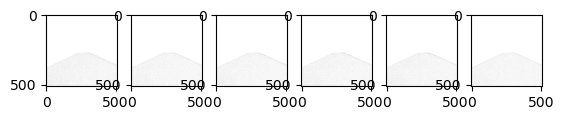

In [10]:
plt.subplot(1,6,1)
plt.imshow(clist[0], cmap='gist_gray')
plt.subplot(1,6,2)
plt.imshow(clist[1], cmap='gist_gray')
plt.subplot(1,6,3)
plt.imshow(clist[2], cmap='gist_gray')
plt.subplot(1,6,4)
plt.imshow(clist[3], cmap='gist_gray')
plt.subplot(1,6,5)
plt.imshow(clist[4], cmap='gist_gray')
plt.subplot(1,6,6)
plt.imshow(clist[5], cmap='gist_gray')



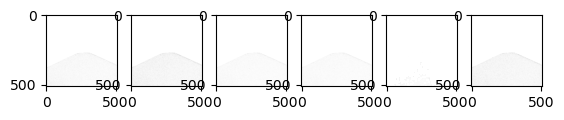

In [11]:
plt.subplot(1,6,1)
plt.imshow(strainlist[7], cmap=white_to_black)
plt.subplot(1,6,2)
plt.imshow(strainlist[8], cmap=white_to_black)
plt.subplot(1,6,3)
plt.imshow(strainlist[9], cmap=white_to_black)
plt.subplot(1,6,4)
plt.imshow(strainlist[10], cmap=white_to_black)
plt.subplot(1,6,5)
plt.imshow(strainlist[11], cmap=white_to_black)
plt.subplot(1,6,6)
plt.imshow(strainlist[12], cmap=white_to_black)

In [10]:
"""

saving the images to a tiff file

"""

#output directory where the individual TIFF files will be saved
output_directory = "2output_images0-200"
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist


#new_width = 2048
#new_height = 2048

for i, img in enumerate(clist):
    output_path = os.path.join(output_directory, f"correlation_image_{i}.tif")
    #resized_img = np.array(Image.fromarray(img).resize((new_width, new_height), Image.LANCZOS))
    img_float32 = img.astype(np.float32)
    imageio.imwrite(output_path, img_float32)
    plt.show()


print("Individual TIFF images exported successfully.")
print("Quality is kind of low, which is why I did 256x256 of 8x8 blocks (size 8 blocksize),\
so there'd be more detail")
print(cwd)

Individual TIFF images exported successfully.
Quality is kind of low, which is why I did 256x256 of 8x8 blocks (size 8 blocksize),so there'd be more detail
u:\Ella_Anderson


In [11]:
"""

saving the images to a tiff file

"""

#output directory where the individual TIFF files will be saved
output_directory = "2outputstrain_images0-200"
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist


#new_width = 2048
#new_height = 2048

for i, img in enumerate(strainlist):
    output_path = os.path.join(output_directory, f"strain_image_{i}.tif")
    #resized_img = np.array(Image.fromarray(img).resize((new_width, new_height), Image.LANCZOS))
    img_float32 = img.astype(np.float32)
    imageio.imwrite(output_path, img_float32)
    plt.show()

In [18]:
!pip install ffmpeg

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6089 sha256=be334df76fd4c0847d2b8ea3975d44534fa5f459b2b623d61ff31120846ac7a6
  Stored in directory: c:\users\burtonlabuser\appdata\local\pip\cache\wheels\e3\61\b9\e9c5cf3d76e5a83f61e4dc835e61ef86af884c2a48b4feeb47
Successfully built ffmpeg


In [8]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
